In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Jobathon

/content/gdrive/My Drive/Jobathon


In [14]:
pip install catboost

     |████████████████████████████████| 65.7MB 58kB/s 


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier , GradientBoostingClassifier , ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings 
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from scipy.stats import mode
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

In [80]:
train_data = pd.read_csv('train.csv')

In [81]:
train_data.isna().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [82]:
test_data = pd.read_csv('test.csv')

In [83]:
train_data.fillna('unknown',inplace=True)
test_data.fillna('unknown',inplace=True)

In [84]:
cols = ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type',
        'Accomodation_Type','Reco_Insurance_Type','Is_Spouse']

In [85]:
train_data['Region_Code_encoded'] , bins = pd.cut(train_data.Region_Code,bins=20,labels=[f'bin_{i}' for i in range(20) ],retbins=True)
test_data['Region_Code_encoded'] = pd.cut(test_data.Region_Code,bins=bins,labels=[f'bin_{i}' for i in range(20) ],retbins=False)

In [86]:
train_data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Region_Code_encoded
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3,22,11628.0,0,bin_10
1,2,C5,1117,Owned,Joint,75,22,No,X2,unknown,unknown,22,30510.0,0,bin_3
2,3,C5,3732,Owned,Individual,32,32,No,unknown,1.0,1,19,7450.0,1,bin_12
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3,19,17780.0,0,bin_14
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1,16,10404.0,0,bin_7


In [87]:
for col in cols + ['City_Code','Region_Code_encoded']:
  encoder = LabelEncoder()
  train_data[col] = encoder.fit_transform(train_data[col].astype(str))
  test_data[col] =  encoder.transform(test_data[col].astype(str))
  try :
    m = encoder.transform(["unknown"])
  except :
    m = None
  
  if m is not None:
    train_data[col] = train_data[col].apply(lambda x: np.NaN if x == m[0] else x)
    test_data[col] = test_data[col].apply(lambda x: np.NaN if x == m[0] else x)

In [88]:
train_data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Region_Code_encoded
0,1,22,3213,1,0,36,36,0,0.0,5.0,2.0,22,11628.0,0,2
1,2,31,1117,0,1,75,22,0,1.0,NaN,NaN,22,30510.0,0,13
2,3,31,3732,0,0,32,32,0,NaN,0.0,0.0,19,7450.0,1,4
3,4,16,4378,0,1,52,48,0,0.0,5.0,2.0,19,17780.0,0,6
4,5,34,2190,1,0,44,44,0,1.0,8.0,0.0,16,10404.0,0,17


In [89]:
cols = ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']

merge = pd.concat([train_data,test_data])

In [90]:
for col in cols:
  X = merge[~merge[col].isna()].drop(['ID',*cols],axis=1)
  Y = merge[~merge[col].isna()][col]
  
  model = LGBMClassifier()
  model.fit(X.drop('Response',axis=1),Y) 
  
  merge['corrected'] = model.predict(merge.drop(['ID','Response',*cols],axis=1))

  merge[col] = merge.apply(lambda x: x['corrected'] if np.isnan(x[col]) else x[col],axis=1)

  merge.drop(['corrected'],axis=1,inplace=True)

In [91]:
X.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Reco_Policy_Cat,Reco_Policy_Premium,Response,Region_Code_encoded
0,22,3213,1,0,36,36,0,22,11628.0,0.0,2
2,31,3732,0,0,32,32,0,19,7450.0,1.0,4
3,16,4378,0,1,52,48,0,19,17780.0,0.0,6
4,34,2190,1,0,44,44,0,16,10404.0,0.0,17
5,35,1785,1,0,52,52,0,22,15264.0,1.0,15


In [92]:
merge['comb_1'] = merge.City_Code.astype(str) + merge.Region_Code.astype(str) 

In [93]:
merge.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Region_Code_encoded,comb_1
0,1,22,3213,1,0,36,36,0,0.0,5.0,2.0,22,11628.0,0.0,2,223213
1,2,31,1117,0,1,75,22,0,1.0,5.0,2.0,22,30510.0,0.0,13,311117
2,3,31,3732,0,0,32,32,0,0.0,0.0,0.0,19,7450.0,1.0,4,313732
3,4,16,4378,0,1,52,48,0,0.0,5.0,2.0,19,17780.0,0.0,6,164378
4,5,34,2190,1,0,44,44,0,1.0,8.0,0.0,16,10404.0,0.0,17,342190


In [95]:
merge['comb_1'].value_counts(normalize = True)

151       0.001926
142       0.001541
1147      0.001486
05        0.001445
04        0.001403
            ...   
315815    0.000014
45988     0.000014
125531    0.000014
315848    0.000014
325928    0.000014
Name: comb_1, Length: 5530, dtype: float64

In [96]:
merge['comb_1'] = merge['comb_1'].map(merge['comb_1'].value_counts(normalize=True))

In [97]:
merge.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Region_Code_encoded,comb_1
0,1,22,3213,1,0,36,36,0,0.0,5.0,2.0,22,11628.0,0.0,2,0.000138
1,2,31,1117,0,1,75,22,0,1.0,5.0,2.0,22,30510.0,0.0,13,0.000289
2,3,31,3732,0,0,32,32,0,0.0,0.0,0.0,19,7450.0,1.0,4,0.000110
3,4,16,4378,0,1,52,48,0,0.0,5.0,2.0,19,17780.0,0.0,6,0.000069
4,5,34,2190,1,0,44,44,0,1.0,8.0,0.0,16,10404.0,0.0,17,0.000193


In [98]:
m = merge.groupby('Region_Code')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()

In [99]:
m.head()

,Region_Code,mean,max,min
0,1,12876.421429,33587.2,3642.0
1,2,13380.501786,34752.0,3456.0
2,4,20943.890196,39276.8,5128.0
3,5,18476.900952,38532.0,5152.0
4,6,15065.941176,36774.4,4792.0


In [100]:
m.columns = ['Region_Code'] + [f'Region_Code_Reco_Policy_Premium_{i}' for i in m.columns[1:]]

In [101]:
m.head()

,Region_Code,Region_Code_Reco_Policy_Premium_mean,Region_Code_Reco_Policy_Premium_max,Region_Code_Reco_Policy_Premium_min
0,1,12876.421429,33587.2,3642.0
1,2,13380.501786,34752.0,3456.0
2,4,20943.890196,39276.8,5128.0
3,5,18476.900952,38532.0,5152.0
4,6,15065.941176,36774.4,4792.0


In [102]:
merge = merge.merge(m,on="Region_Code",how="left")

In [103]:
merge.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Region_Code_encoded,comb_1,Region_Code_Reco_Policy_Premium_mean,Region_Code_Reco_Policy_Premium_max,Region_Code_Reco_Policy_Premium_min
0,1,22,3213,1,0,36,36,0,0.0,5.0,2.0,22,11628.0,0.0,2,0.000138,12130.080000,27596.8,4002.0
1,2,31,1117,0,1,75,22,0,1.0,5.0,2.0,22,30510.0,0.0,13,0.000289,16076.342857,39398.4,4074.0
2,3,31,3732,0,0,32,32,0,0.0,0.0,0.0,19,7450.0,1.0,4,0.000110,11336.000000,19680.0,5344.0
3,4,16,4378,0,1,52,48,0,0.0,5.0,2.0,19,17780.0,0.0,6,0.000069,14329.200000,17780.0,10962.0
4,5,34,2190,1,0,44,44,0,1.0,8.0,0.0,16,10404.0,0.0,17,0.000193,16664.157143,22932.0,9328.0


In [107]:
m= merge.groupby('comb_1')['Reco_Policy_Premium'].agg(['min' , 'max' , 'mean']).reset_index()
m.columns = ['comb_1'] + [f'comb_1_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m , on = 'comb_1' , how = 'left')

In [108]:
merge['comb_2'] = merge.City_Code.astype(str) + merge.Reco_Policy_Cat.astype(str)
merge['comb_2'] = merge['comb_2'].map(merge['comb_2'].value_counts(normalize = True))

In [110]:
m = merge.groupby('Reco_Policy_Cat')['Reco_Policy_Premium'].agg(['mean' , 'max' , 'min']).reset_index()
m.column = ['Reco_Policy_Cat'] + [f'Reco_Policy_Cat_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m, on = 'Reco_Policy_Cat' , how = 'left')

In [111]:
m = merge.groupby('comb_2')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_2'] + [f'comb_2_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_2",how="left")

In [112]:
merge['comb_3'] = merge.Region_Code.astype(str) + merge.Reco_Policy_Cat.astype(str) 
merge['comb_3'] = merge['comb_3'].map(merge['comb_3'].value_counts(normalize=True))

In [113]:
m = merge.groupby('comb_3')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_3'] + [f'comb_3_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_3",how="left")

In [114]:
merge['comb_4'] = merge.City_Code.astype(str) + merge.Reco_Policy_Cat.astype(str) + merge.Region_Code.astype(str) 
merge['comb_4'] = merge['comb_4'].map(merge['comb_4'].value_counts(normalize=True))

In [115]:
m = merge.groupby('comb_4')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_4'] + [f'comb_4_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_4",how="left")

In [116]:
m = merge.groupby('Region_Code')['Upper_Age'].agg(['mean']).reset_index()
m.columns = ['Region_Code'] + [f'Region_Code_Upper_Age_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Region_Code",how="left")

In [117]:
merge['comb_5'] = merge.Reco_Policy_Cat.astype(str) + merge.Holding_Policy_Type.astype(str)
merge['comb_5'] = merge['comb_5'].map(merge['comb_5'].value_counts(normalize=True))

In [118]:
m = merge.groupby('comb_5')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_5'] + [f'comb_5_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_5",how="left")

In [119]:
m = merge.groupby('Reco_Policy_Cat')['Upper_Age'].agg(['mean']).reset_index()
m.columns = ['Reco_Policy_Cat'] + [f'Reco_Policy_Cat_Upper_Age_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Reco_Policy_Cat",how="left")

In [120]:
merge['comb_6'] = merge.City_Code.astype(str) + merge.Holding_Policy_Type.astype(str)
merge['comb_6'] = merge['comb_6'].map(merge['comb_6'].value_counts(normalize=True))

In [121]:
m = merge.groupby('comb_6')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_6'] + [f'comb_6_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_6",how="left")

In [122]:
m = merge.groupby('Health Indicator')['Reco_Policy_Premium'].agg(['mean']).reset_index()
m.columns = ['Health Indicator'] + [f'Health Indicator_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Health Indicator",how="left")

In [123]:
m = merge.groupby('Holding_Policy_Duration')['Reco_Policy_Premium'].agg(['mean']).reset_index()
m.columns = ['Holding_Policy_Duration'] + [f'Holding_Policy_Duration_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Holding_Policy_Duration",how="left")

In [124]:
m = merge.groupby('Reco_Policy_Cat')['Region_Code'].agg(['nunique','count']).reset_index()
m.columns = ['Reco_Policy_Cat'] + [f'Reco_Policy_Cat_Region_Code_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Reco_Policy_Cat",how="left")

In [125]:
merge['comb_7'] = merge.City_Code.astype(str) + merge.Holding_Policy_Duration.astype(str)
merge['comb_7'] = merge['comb_7'].map(merge['comb_7'].value_counts(normalize=True))

In [126]:
merge['comb_8'] = merge.City_Code.astype(str) + merge['Health Indicator'].astype(str)
merge['comb_8'] = merge['comb_8'].map(merge['comb_8'].value_counts(normalize=True))

In [127]:
merge['comb_9'] = merge.Reco_Policy_Cat.astype(str) + merge['Health Indicator'].astype(str)
merge['comb_9'] = merge['comb_9'].map(merge['comb_9'].value_counts(normalize=True))

In [128]:
m = merge.groupby('comb_7')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_7'] + [f'comb_7_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_7",how="left")

In [129]:
m = merge.groupby('comb_2')['comb_4'].agg(['nunique','count']).reset_index()
m.columns = ['comb_2'] + [f'comb_2_comb_4_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_2",how="left")

In [130]:
m = merge.groupby('comb_1')['comb_4'].agg(['nunique','count']).reset_index()
m.columns = ['comb_1'] + [f'comb_1_comb_4_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_1",how="left")

In [131]:
train_data = merge[~merge.Response.isna()]
test_data = merge[merge.Response.isna()].drop('Response',axis=1)

train_data

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Region_Code_encoded,comb_1,Region_Code_Reco_Policy_Premium_mean,Region_Code_Reco_Policy_Premium_max,Region_Code_Reco_Policy_Premium_min,comb_1_Reco_Policy_Premium_mean_x,comb_1_Reco_Policy_Premium_max_x,comb_1_Reco_Policy_Premium_min_x,comb_1_Reco_Policy_Premium_min_y,comb_1_Reco_Policy_Premium_max_y,comb_1_Reco_Policy_Premium_mean_y,comb_2,mean,max,min,comb_2_Reco_Policy_Premium_mean,comb_2_Reco_Policy_Premium_max,comb_2_Reco_Policy_Premium_min,comb_3,comb_3_Reco_Policy_Premium_mean,comb_3_Reco_Policy_Premium_max,comb_3_Reco_Policy_Premium_min,comb_4,comb_4_Reco_Policy_Premium_mean,comb_4_Reco_Policy_Premium_max,comb_4_Reco_Policy_Premium_min,Region_Code_Upper_Age_mean,comb_5,comb_5_Reco_Policy_Premium_mean,comb_5_Reco_Policy_Premium_max,comb_5_Reco_Policy_Premium_min,Reco_Policy_Cat_Upper_Age_mean,comb_6,comb_6_Reco_Policy_Premium_mean,comb_6_Reco_Policy_Premium_max,comb_6_Reco_Policy_Premium_min,Health Indicator_Reco_Policy_Premium_mean,Holding_Policy_Duration_Reco_Policy_Premium_mean,Reco_Policy_Cat_Region_Code_nunique,Reco_Policy_Cat_Region_Code_count,comb_7,comb_8,comb_9,comb_7_Reco_Policy_Premium_mean,comb_7_Reco_Policy_Premium_max,comb_7_Reco_Policy_Premium_min,comb_2_comb_4_nunique,comb_2_comb_4_count,comb_1_comb_4_nunique,comb_1_comb_4_count
0,1,22,3213,1,0,36,36,0,0.0,5.0,2.0,22,11628.0,0.0,2,0.000138,12130.080000,27596.8,4002.0,14164.909296,40550.4,2624.0,2624.0,40550.4,14164.909296,0.007292,14589.814674,42316.8,2464.0,14070.144906,35037.0,2712.0,0.000014,14066.644022,42739.2,2400.0,0.000014,14074.029042,42739.2,2400.0,40.700000,0.069105,14003.593988,42256.0,2464.0,44.595306,0.044258,13765.574510,41496.0,2548.0,13587.189675,18459.859390,2862,9459,0.018201,0.043529,0.050697,17973.844747,41496.0,6696.0,13,530,10,2130
1,2,31,1117,0,1,75,22,0,1.0,5.0,2.0,22,30510.0,0.0,13,0.000289,16076.342857,39398.4,4074.0,14256.315580,39960.0,2600.0,2600.0,39960.0,14256.315580,0.001458,14589.814674,42316.8,2464.0,14318.756604,39398.4,3984.0,0.000220,14209.203549,39398.4,2700.0,0.000220,14061.558333,39398.4,2700.0,41.333333,0.069105,14003.593988,42256.0,2464.0,44.595306,0.012423,13430.287929,36448.0,2736.0,15079.031053,18459.859390,2862,9459,0.004347,0.006191,0.035921,18339.926582,37962.0,7994.0,8,212,19,2163
2,3,31,3732,0,0,32,32,0,0.0,0.0,0.0,19,7450.0,1.0,4,0.000110,11336.000000,19680.0,5344.0,14079.977220,38476.8,2472.0,2472.0,38476.8,14079.977220,0.001596,14714.576838,43046.4,2624.0,12584.374138,35872.0,2508.0,0.000028,13973.244532,41648.0,2152.0,0.000028,13947.101367,41648.0,2152.0,35.125000,0.053462,13829.736644,43046.4,2624.0,45.305697,0.008145,13000.609797,39398.4,3678.0,13587.189675,11068.057509,1599,5319,0.009011,0.012437,0.034532,11444.826870,39398.4,2736.0,12,348,8,1712
3,4,16,4378,0,1,52,48,0,0.0,5.0,2.0,19,17780.0,0.0,6,0.000069,14329.200000,17780.0,10962.0,14280.527336,37590.4,2668.0,2668.0,37590.4,14280.527336,0.001169,14714.576838,43046.4,2624.0,14964.381176,43046.4,3624.0,0.000014,14066.644022,42739.2,2400.0,0.000014,14074.029042,42739.2,2400.0,48.400000,0.011240,17766.363525,40550.4,3930.0,45.305697,0.002944,16259.319626,42012.8,3972.0,13587.189675,18459.859390,1599,5319,0.002339,0.004375,0.034532,18130.344706,42012.8,8386.0,9,255,5,1145
4,5,34,2190,1,0,44,44,0,1.0,8.0,0.0,16,10404.0,0.0,17,0.000193,16664.157143,22932.0,9328.0,14301.799689,38851.2,2512.0,2512.0,38851.2,14301.799689,0.003192,14264.687867,39528.0,2380.0,13681.716379,34054.4,2488.0,0.000151,14319.653641,43776.0,2908.0,0.000151,14293.252217,43776.0,2908.0,49.785714,0.056475,13474.317125,37900.8,2380.0,44.441410,0.008475,12011.247078,33792.0,2472.0,15079.031053,13088.703172,1857,5786,0.003316,0.009369,0.018449,12079.000000,37574.4,3564.0,14,464,14,2576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [132]:
from sklearn.preprocessing import StandardScaler

X = train_data.drop(['Response','ID'],axis=1)
Y = train_data['Response']

folds = StratifiedKFold(n_splits=6,shuffle=True ,random_state=42)

final_preds = pd.DataFrame()
scores = []
best_score = 0

for i , (train_idx, test_idx) in enumerate(folds.split(X,Y)):
  train_set=(X.iloc[train_idx],Y.iloc[train_idx])
  test_set=(X.iloc[test_idx],Y.iloc[test_idx])

  model = LGBMClassifier(metric="auc",
                         learning_rate = 0.08,
                         n_estimators=5000,
                         num_leaves=20,
                         random_state=7,
                        #  subsample=0.95
                        #  reg_alpha=0.001,
                        #  reg_lambda=0.01
                         )
  model.fit(*train_set,
            eval_set=(test_set),
            verbose=500,
            early_stopping_rounds=500)
    
  preds = model.predict_proba(test_set[0])[:,1]
  score = roc_auc_score(test_set[1],preds)
  print("Score:: ",score)
  scores.append(score)

  if best_score < score:
    best_model = model
    best_score = score

  predictions = model.predict_proba(test_data.drop('ID',axis=1))[:,1]
  final_preds[i] = predictions

  # break

print('Mean Score',np.mean(scores))

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.796243
Early stopping, best iteration is:
[124]	valid_0's auc: 0.800079
Score::  0.8000790159182961
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.813354
Early stopping, best iteration is:
[313]	valid_0's auc: 0.814352
Score::  0.8143518522047842
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.807679
Early stopping, best iteration is:
[191]	valid_0's auc: 0.811411
Score::  0.8114106421062235
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.801383
Early stopping, best iteration is:
[125]	valid_0's auc: 0.803779
Score::  0.8037792853153598
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.801038
Early stopping, best iteration is:
[291]	valid_0's auc: 0.80318
Score::  0.8031796547234871
Training until validation scores don't improve for 500 rounds.
[500]	va

In [133]:
pd.DataFrame(list(zip(X.columns,best_model.feature_importances_))).sort_values(1,ascending=False)

,0,1
11,Reco_Policy_Premium,271
16,Region_Code_Reco_Policy_Premium_min,219
38,Region_Code_Upper_Age_mean,193
1,Region_Code,186
34,comb_4,183
...,...,...
6,Is_Spouse,8
3,Reco_Insurance_Type,2
20,comb_1_Reco_Policy_Premium_min_y,0
21,comb_1_Reco_Policy_Premium_max_y,0


In [134]:
submission = pd.DataFrame(np.mean(final_preds,axis=1),columns=['Response'])
submission['ID'] = test_data.ID.values
submission  = submission[['ID','Response']]

In [135]:
from sklearn.preprocessing import StandardScaler

X = train_data.drop(['Response','ID'],axis=1)
Y = train_data['Response']

folds = StratifiedKFold(n_splits=6,shuffle=True ,random_state=42)

final_preds = pd.DataFrame()
scores = []
best_score = 0

for i , (train_idx, test_idx) in enumerate(folds.split(X,Y)):
  train_set=(X.iloc[train_idx],Y.iloc[train_idx])
  test_set=(X.iloc[test_idx],Y.iloc[test_idx])

  model = CatBoostClassifier(eval_metric="AUC",
                            learning_rate = 0.08,
                            n_estimators=5000,
                            # num_leaves=20,
                            random_state=7,
                            #  subsample=0.95
                        #  reg_alpha=0.001,
                        #  reg_lambda=0.01
                         )
  model.fit(*train_set,
            eval_set=(test_set),
            verbose=500,
            early_stopping_rounds=500)
    
  preds = model.predict_proba(test_set[0])[:,1]
  score = roc_auc_score(test_set[1],preds)
  print("Score:: ",score)
  scores.append(score)

  if best_score < score:
    best_model = model
    best_score = score

  predictions = model.predict_proba(test_data.drop('ID',axis=1))[:,1]
  final_preds[i] = predictions

  # break

print('Mean Score',np.mean(scores))

0:	test: 0.7303666	best: 0.7303666 (0)	total: 90.7ms	remaining: 7m 33s
500:	test: 0.7995012	best: 0.8000017 (353)	total: 17.4s	remaining: 2m 36s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8000016771
bestIteration = 353

Shrink model to first 354 iterations.
Score::  0.800001677134783
0:	test: 0.7530897	best: 0.7530897 (0)	total: 39ms	remaining: 3m 15s
500:	test: 0.8115250	best: 0.8130276 (363)	total: 17.5s	remaining: 2m 36s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8130275637
bestIteration = 363

Shrink model to first 364 iterations.
Score::  0.8130275637101576
0:	test: 0.7377073	best: 0.7377073 (0)	total: 35ms	remaining: 2m 54s
500:	test: 0.8110431	best: 0.8112894 (331)	total: 17.6s	remaining: 2m 37s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8112893714
bestIteration = 331

Shrink model to first 332 iterations.
Score::  0.8112893714089763
0:	test: 0.7372677	best: 0.7372677 (0)	total: 33.5ms	remaining: 2m 47

In [136]:
submission = pd.DataFrame(np.mean(final_preds,axis=1),columns=['Response'])
submission['ID'] = test_data.ID.values
submission  = submission[['ID','Response']]

In [ ]:
X = df.drop(['Response'] , axis = 1)
y = df['Response']

In [ ]:
X.columns

Index(['Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age',
       'Lower_Age', 'Is_Spouse', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium', 'C1',
       'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19',
       'C2', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28',
       'C29', 'C3', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',
       'X8', 'X9'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
import keras
import tensorflow as tf

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(4, activation='relu'),    
    keras.layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(optimizer= opt,loss='binary_crossentropy',metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/10
15395/35617 [===========>..................] - ETA: 20s - loss: 39.7410 - accuracy: 0.6733

KeyboardInterrupt: ignored

In [ ]:
model.compile(optimizer= opt,loss='binary_crossentropy',metrics= [tf.keras.metrics.AUC()])

model.fit(X_train, y_train, epochs=10, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/10
35617/35617 [==============================] - 39s 1ms/step - loss: 0.6649 - auc_3: 0.4907
Epoch 2/10
35617/35617 [==============================] - 38s 1ms/step - loss: 0.6707 - auc_3: 0.4930
Epoch 3/10
35617/35617 [==============================] - 37s 1ms/step - loss: 0.6560 - auc_3: 0.4974
Epoch 4/10
35617/35617 [==============================] - 37s 1ms/step - loss: 0.6576 - auc_3: 0.5123
Epoch 5/10
35617/35617 [==============================] - 37s 1ms/step - loss: 0.6442 - auc_3: 0.5125
Epoch 6/10
35617/35617 [==============================] - 38s 1ms/step - loss: 0.6392 - auc_3: 0.5227
Epoch 7/10
35617/35617 [==============================] - 37s 1ms/step - loss: 0.6351 - auc_3: 0.5331
Epoch 8/10
35617/35617 [==============================] - 37s 1ms/step - loss: 0.6214 - auc_3: 0.5384
Epoch 9/10
35617/35617 [==============================] - 36s 1ms/step - loss: 0.6245 - auc_3: 0.5321
Epoch 10/10
478/478 [==============================] - 1s 1ms/step - loss: 0.5894 

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
model_lr = LogisticRegression(solver = 'liblinear')
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predicted_classes_lr = model_lr.predict(X_test)

In [ ]:
predicted_classes_lr_prob = model_lr.predict_proba(X_test)

In [ ]:
accuracy_lr = accuracy_score(y_test, predicted_classes_lr)
print("accuracy score for LR model::", accuracy_lr)

accuracy score for LR model:: 0.754208974778906


In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_test,predicted_classes_lr)

0.5

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

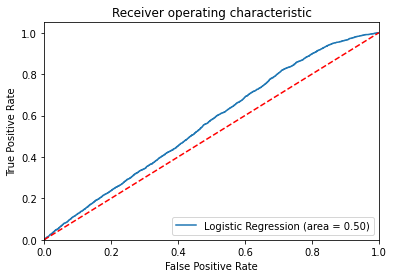

In [ ]:
logit_roc_auc = roc_auc_score(y_test, model_lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
   t = threshould[np.argmax(tpr*(1-fpr))]
   # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
   print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
   return t

In [ ]:
from math import *

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, model_lr.predict_proba(X_test)[:,1])
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.210091


In [ ]:
THRESHOLD = 0.215898

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score


In [ ]:
preds = np.where(model_lr.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.427448
recall,0.793443
precision,0.272071
roc_auc_score,0.550808


In [ ]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
predicted_classes_nb = model_nb.predict(X_test)

In [ ]:
accuracy_nb = accuracy_score(y_test, predicted_classes_nb)
print("accuracy score for NB model::", accuracy_nb)

accuracy score for NB model:: 0.7014739600393056


In [ ]:
roc_auc_score(y_test,predicted_classes_nb)

0.49333694486829294

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors = 2)
# fitting model
model_knn.fit(X_train,y_train)
#predict
predicted_classes_knn = model_knn.predict(X_test)

In [ ]:
accuracy_knn = accuracy_score(y_test, predicted_classes_knn)
print("accuracy score for KNN model::", accuracy_knn)

accuracy score for KNN model:: 0.7273501473960039


In [ ]:
roc_auc_score(y_test,predicted_classes_knn)

0.5002504932312541

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
neighbors = list(range(1,10,2))
# empty list that will hold cv scores
cv_scores = [ ]
#perform 10-fold cross-validation
for K in neighbors:
    model_knn = KNeighborsClassifier(n_neighbors = K)
    scores = cross_val_score(model_knn,X_train,y_train,cv = 10,scoring =
    "accuracy")
    cv_scores.append(scores.mean())

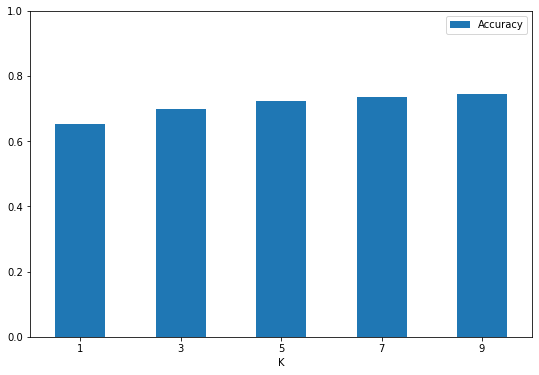

In [ ]:
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,10,2)],
                  "Accuracy":knn_list_scores}).set_index("K").plot.bar(figsize= (9,6),ylim=(0.0,1.00),rot=0)
    plt.show()
plot_accuracy(cv_scores)

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors = 5)
# fitting model
model_knn.fit(X_train,y_train)
#predict
predicted_classes_knn = model_knn.predict(X_test)

In [ ]:
accuracy_knn = accuracy_score(y_test, predicted_classes_knn)
print("accuracy score for KNN model::", accuracy_knn)

accuracy score for KNN model:: 0.7142482803799541


In [ ]:
roc_auc_score(y_test,predicted_classes_knn)

0.505758288535237

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)
DecisionTreeClassifier()
predicted_classes_dt = model_dt.predict(X_test)

In [ ]:
accuracy_dt = accuracy_score(y_test, predicted_classes_dt)
print("accuracy score  for DT model::", accuracy_dt)

accuracy score  for DT model:: 0.6725188339338356


In [ ]:
roc_auc_score(y_test,predicted_classes_dt)

0.5551707030172807

In [ ]:
model_dt1 = DecisionTreeClassifier(criterion = 'entropy')
model_dt1.fit(X_train,y_train)
predicted_classes_dt1 = model_dt1.predict(X_test)

accuracy_dt1 = accuracy_score(y_test, predicted_classes_dt1)
print("accuracy score  for DT model::", accuracy_dt1)

accuracy score  for DT model:: 0.672125777923354


In [ ]:
roc_auc_score(y_test,predicted_classes_dt1)

0.5531134661531222

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train,y_train)
predicted_classes_rf = model_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, predicted_classes_rf)
print("accuracy score for RF model::", accuracy_rf)

accuracy score for RF model:: 0.7502784146740911


In [ ]:
roc_auc_score(y_test,predicted_classes_rf)

0.5070063909399165

In [ ]:
model_rf = RandomForestClassifier(criterion = 'entropy')
model_rf.fit(X_train,y_train)
predicted_classes_rf = model_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, predicted_classes_rf)
print("accuracy score for RF model::", accuracy_rf)

accuracy score for RF model:: 0.7502784146740911


In [ ]:
roc_auc_score(y_test,predicted_classes_rf)

0.506647058567519

In [ ]:
from sklearn.svm import SVC
model_svm = SVC()
model_svm.fit(X_train,y_train)
predicted_classes_svm = model_svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, predicted_classes_svm)
print("accuracy score for SVM model::", accuracy_svm)

accuracy score for SVM model:: 0.754208974778906


In [ ]:
roc_auc_score(y_test,predicted_classes_svm)

0.5

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
model_sgdc = OneVsRestClassifier(SGDClassifier())
model_sgdc.fit(X_train,y_train)
predicted_classes_sgdc = model_sgdc.predict(X_test)


accuracy_sgdc = accuracy_score(y_test, predicted_classes_sgdc)
print("accuracy score for SGDC model::", accuracy_sgdc)

accuracy score for SGDC model:: 0.7325253848673436


In [ ]:
roc_auc_score(y_test,predicted_classes_sgdc)

0.5062865571263929

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train,y_train)
predicted_classes_lda = model_lda.predict(X_test)

accuracy_lda = accuracy_score(y_test, predicted_classes_lda)
print("accuracy score for LDA model::", accuracy_lda)

accuracy score for LDA model:: 0.754208974778906


In [ ]:
roc_auc_score(y_test,predicted_classes_lda)

0.5

In [ ]:
predicted_classes_dt_prob = model_dt.predict_proba(test)
predicted_classes_dt_prob.shape

(21805, 2)

In [ ]:
Pred = pd.DataFrame(predicted_classes_dt_prob) 

In [ ]:
Pred.to_csv('5.csv')